In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
import datetime
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [2]:
car_price_train = pd.read_csv(r"C:\Users\HP\Downloads\playground-series-s4e9\train.csv")
car_price_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [3]:
car_price_train.shape

(188533, 13)

In [4]:
car_price_test = pd.read_csv(r"C:\Users\HP\Downloads\playground-series-s4e9\test.csv")
car_price_test.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [5]:
car_price_test.shape

(125690, 12)

In [6]:
car_price_train.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [7]:
car_price_test.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

In [8]:
car_price_train.describe(include ='all')

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
count,188533.000000,188533,188533,188533.000000,188533.000000,183450,188533,188533,188533,188533,186081,167114,1.885330e+05
unique,NaN,57,1897,NaN,NaN,7,1117,52,319,156,2,1,NaN
top,NaN,Ford,F-150 XLT,NaN,NaN,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,NaN
freq,NaN,23088,2945,NaN,NaN,165940,3462,49904,48658,107674,144514,167114,NaN
mean,94266.000000,NaN,NaN,2015.829998,65705.295174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.387802e+04
std,54424.933488,NaN,NaN,5.660967,49798.158076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.881952e+04
min,0.000000,NaN,NaN,1974.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+03
25%,47133.000000,NaN,NaN,2013.000000,24115.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.700000e+04
50%,94266.000000,NaN,NaN,2017.000000,57785.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.082500e+04
75%,141399.000000,NaN,NaN,2020.000000,95400.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.990000e+04


In [9]:
car_price_test.describe(include ='all')

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
count,125690.000000,125690,125690,125690.000000,125690.000000,122307,125690,125690,125690,125690,124058,111451
unique,NaN,55,1891,NaN,NaN,7,1117,52,317,156,2,1
top,NaN,Ford,F-150 XLT,NaN,NaN,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
freq,NaN,15265,1923,NaN,NaN,110533,2189,33132,32370,71613,96263,111451
mean,251377.500000,NaN,NaN,2015.797526,66042.581510,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,36283.722005,NaN,NaN,5.673797,50223.858435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,188533.000000,NaN,NaN,1974.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,219955.250000,NaN,NaN,2013.000000,24500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,251377.500000,NaN,NaN,2017.000000,57500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,282799.750000,NaN,NaN,2020.000000,95798.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
car_price_train.isnull().mean()*100

id               0.000000
brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64

In [11]:
car_price_test.isnull().mean()*100

id               0.000000
brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.691543
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.298433
clean_title     11.328666
dtype: float64

In [12]:
print("Value counts of train :",car_price_train.fuel_type.value_counts(),"Value counts of test", car_price_test.fuel_type.value_counts())

Value counts of train : fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64 Value counts of test fuel_type
Gasoline          110533
Hybrid              4676
E85 Flex Fuel       3523
Diesel              2686
–                    538
Plug-In Hybrid       337
not supported         14
Name: count, dtype: int64


In [13]:
print("Value counts of train :",car_price_train.clean_title.value_counts(),"Value counts of test", car_price_test.clean_title.value_counts())

Value counts of train : clean_title
Yes    167114
Name: count, dtype: int64 Value counts of test clean_title
Yes    111451
Name: count, dtype: int64


In [14]:
print("Value counts of train :",car_price_train.accident.value_counts(),"Value counts of test", car_price_test.accident.value_counts())

Value counts of train : accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64 Value counts of test accident
None reported                             96263
At least 1 accident or damage reported    27795
Name: count, dtype: int64


In [15]:
car_price_train['fuel_type'].fillna('Electricity', inplace=True)
car_price_test['fuel_type'].fillna('Electricity', inplace=True)

In [16]:
car_price_train['clean_title'].fillna('No', inplace=True)
car_price_test['clean_title'].fillna('No', inplace=True)

In [17]:
car_price_train['accident'].fillna('None reported', inplace=True)
car_price_test['accident'].fillna('None reported', inplace=True)

In [18]:
car_price_train.isnull().sum()

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [19]:
car_price_test.isnull().sum()

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64

In [20]:
car_price_train.head(6)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
5,5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950


In [21]:
print("Value counts of train :",car_price_train.engine.value_counts())

Value counts of train : engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel           3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel           2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel           2841
2.0L I4 16V GDI DOHC Turbo                             2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel          2451
                                                       ... 
151.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid        1
184.0HP 2.4L 4 Cylinder Engine Flex Fuel Capability       1
78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel               1
139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas       1
313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas       1
Name: count, Length: 1117, dtype: int64


In [22]:
def extract_engine_feature(engine):
    hp = re.search(r'(\d+\.?\d*)HP', engine)
    hp_value = float(hp.group(1)) if hp else None
    # Extract engine liter in Size
    size = re.search(r'(\d+\.?\d*)L', engine)
    size_value = float(size.group(1)) if size else None
    # Extract Cylinders
    cylinders = re.search(r'(\d+)\s*Cylinder', engine)
    cylinders_value = int(cylinders.group(1)) if cylinders else None
    # Extract a fuel type
    fuel_type = None
    if 'Gasoline' in engine:
        fuel_type = 'Gasoline'
    elif 'Hybrid' in engine:
        fuel_type = 'Hybrid'
    elif 'Flex Fuel' in engine:
        fuel_type = 'Flex Fuel'
    elif 'Diesel' in engine:
        fuel_type = 'Diesel'
    elif 'Plug-In Electric' in engine:
        fuel_type = 'Plug-In Electric'
    elif 'Turbo' in engine:
        fuel_type = 'Turbo'

    return pd.Series([hp_value, size_value, cylinders_value, fuel_type])
car_price_train[['Horsepower', 'Engine_Size_L', 'Cylinders', 'Fuel_Type']] = car_price_train['engine'].apply(extract_engine_feature)
car_price_test[['Horsepower', 'Engine_Size_L', 'Cylinders', 'Fuel_Type']] = car_price_train['engine'].apply(extract_engine_feature)

In [23]:
car_price_train.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Engine_Size_L,Cylinders,Fuel_Type
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4.0,Gasoline
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8.0,Gasoline
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8.0,Flex Fuel
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8.0,Gasoline
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4.0,Gasoline


In [24]:
current_year = datetime.datetime.now().year

In [25]:
car_price_train['model_age'] = current_year - car_price_train['model_year']
car_price_test['model_age'] = current_year - car_price_test['model_year']
car_price_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Engine_Size_L,Cylinders,Fuel_Type,model_age
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4.0,Gasoline,17
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8.0,Gasoline,22
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8.0,Flex Fuel,22
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8.0,Gasoline,7
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4.0,Gasoline,3


In [26]:
train_drop = car_price_train.drop(columns=['model', 'model_year', 'engine','Fuel_Type'], inplace=False)
train_drop.head(5)

,id,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Engine_Size_L,Cylinders,model_age
0,0,MINI,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4.0,17
1,1,Lincoln,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8.0,22
2,2,Chevrolet,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8.0,22
3,3,Genesis,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8.0,7
4,4,Mercedes-Benz,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4.0,3


In [27]:
test_drop=car_price_test.drop(columns=['model', 'model_year', 'engine','Fuel_Type'], inplace=False)

In [28]:
train_drop.isnull().mean()*100

id                0.000000
brand             0.000000
milage            0.000000
fuel_type         0.000000
transmission      0.000000
ext_col           0.000000
int_col           0.000000
accident          0.000000
clean_title       0.000000
price             0.000000
Horsepower       17.640943
Engine_Size_L     7.539264
Cylinders        20.078713
model_age         0.000000
dtype: float64

In [29]:
numeric_column = train_drop.select_dtypes(include=['float64', 'int64'])[['Horsepower', 'Engine_Size_L', 'Cylinders']]
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
imputed_values = iterative_imputer.fit_transform(numeric_column)
train_drop[['Horsepower', 'Engine_Size_L', 'Cylinders']] = imputed_values
train_drop.head()

,id,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Engine_Size_L,Cylinders,model_age
0,0,MINI,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4.0,17
1,1,Lincoln,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8.0,22
2,2,Chevrolet,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8.0,22
3,3,Genesis,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8.0,7
4,4,Mercedes-Benz,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4.0,3


In [30]:
numeric_column = test_drop.select_dtypes(include=['float64', 'int64'])[['Horsepower', 'Engine_Size_L', 'Cylinders']]
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
imputed_values = iterative_imputer.fit_transform(numeric_column)
test_drop[['Horsepower', 'Engine_Size_L', 'Cylinders']] = imputed_values
test_drop.head()

,id,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,Horsepower,Engine_Size_L,Cylinders,model_age
0,188533,Land,98000,Gasoline,6-Speed A/T,White,Beige,None reported,Yes,172.0,1.6,4.0,9
1,188534,Land,9142,Hybrid,8-Speed A/T,Silver,Black,None reported,Yes,252.0,3.9,8.0,4
2,188535,Ford,28121,Gasoline,10-Speed Automatic,White,Ebony,None reported,No,320.0,5.3,8.0,2
3,188536,Audi,61258,Gasoline,Automatic,Silician Yellow,Black,None reported,No,420.0,5.0,8.0,8
4,188537,Audi,59000,Gasoline,A/T,Gray,Black,None reported,Yes,208.0,2.0,4.0,6


In [31]:
train_drop.isnull().sum()

id               0
brand            0
milage           0
fuel_type        0
transmission     0
ext_col          0
int_col          0
accident         0
clean_title      0
price            0
Horsepower       0
Engine_Size_L    0
Cylinders        0
model_age        0
dtype: int64

In [32]:
def map_transmission(transmission):
    transmission = transmission.strip().lower()
    transmission_map = {'a/t': 'Automatic', 'automatic': 'Automatic','m/t': 'Manual', 'manual': 'Manual',
        'cvt': 'Variator', 'variator': 'Variator',
        'tiptronic': 'Tiptronic'}
    return next((value for key, value in transmission_map.items() if key in transmission), 'Other')


In [33]:
train_drop['transmission'] = train_drop['transmission'].apply(map_transmission)
test_drop['transmission'] = test_drop['transmission'].apply(map_transmission)

print(train_drop['transmission'].value_counts())
print(test_drop['transmission'].value_counts())

transmission
Automatic    150302
Other         19868
Manual        16358
Variator       2005
Name: count, dtype: int64
transmission
Automatic    100296
Other         13260
Manual        10785
Variator       1349
Name: count, dtype: int64


In [34]:
train_drop.head()

,id,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Engine_Size_L,Cylinders,model_age
0,0,MINI,213000,Gasoline,Automatic,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4.0,17
1,1,Lincoln,143250,Gasoline,Automatic,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8.0,22
2,2,Chevrolet,136731,E85 Flex Fuel,Automatic,Blue,Gray,None reported,Yes,13900,320.0,5.3,8.0,22
3,3,Genesis,19500,Gasoline,Other,Black,Black,None reported,Yes,45000,420.0,5.0,8.0,7
4,4,Mercedes-Benz,7388,Gasoline,Automatic,Black,Beige,None reported,Yes,97500,208.0,2.0,4.0,3


In [35]:
def replace_values(data):
    data['accident'] = data['accident'].replace({'At least 1 accident or damage reported': 1, 'None reported': 0})
    data['clean_title'] = data['clean_title'].replace({'Yes': 1, 'No': 0})
    data['transmission'] = data['transmission'].replace({'Automatic': 1, 'Manual': 2, 'Variator': 3, 'Other': 4})
    return data

In [36]:
train_drop = replace_values(train_drop)
test_drop = replace_values(test_drop)

In [37]:
train_drop.tail()

,id,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Engine_Size_L,Cylinders,model_age
188528,188528,Cadillac,49000,Gasoline,4,White,Beige,0,1,27500,420.000000,6.2,8.000000,7
188529,188529,Mercedes-Benz,28600,Gasoline,1,White,Black,1,1,30000,385.000000,3.0,6.000000,6
188530,188530,Mercedes-Benz,13650,Gasoline,1,White,Black,0,1,86900,469.000000,4.0,8.000000,3
188531,188531,Audi,13895,Gasoline,1,Daytona Gray Pearl Effect,Black,0,0,84900,298.356533,3.0,5.537382,2
188532,188532,Porsche,59500,Gasoline,4,White,Black,0,1,28995,252.000000,2.0,4.000000,8


In [38]:
from sklearn.preprocessing import LabelEncoder

In [39]:
label=LabelEncoder()

In [40]:
for col in ['brand', 'ext_col','int_col','fuel_type']:
    train_drop[col] = label.fit_transform(train_drop[col])
    test_drop[col] = label.fit_transform(test_drop[col])

In [41]:
train_drop.head(5)

,id,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Engine_Size_L,Cylinders,model_age
0,0,31,213000,3,1,312,71,0,1,4200,172.0,1.6,4.0,17
1,1,28,143250,3,1,263,10,1,1,4999,252.0,3.9,8.0,22
2,2,9,136731,1,1,38,71,0,1,13900,320.0,5.3,8.0,22
3,3,16,19500,3,4,29,14,0,1,45000,420.0,5.0,8.0,7
4,4,36,7388,3,1,29,10,0,1,97500,208.0,2.0,4.0,3


In [42]:
print(train_drop.columns)


Index(['id', 'brand', 'milage', 'fuel_type', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title', 'price', 'Horsepower',
       'Engine_Size_L', 'Cylinders', 'model_age'],
      dtype='object')


In [43]:
train_drop['price'] = np.log1p(train_drop['price'])

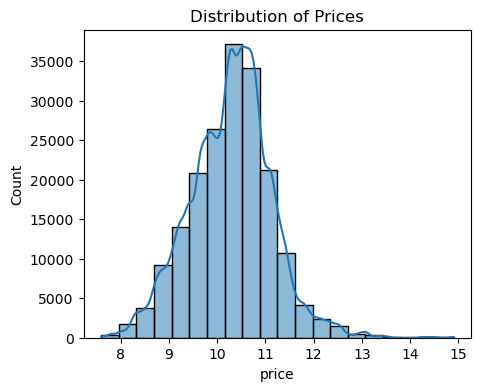

In [44]:
# After skewness the data
plt.figure(figsize=(5, 4))
sns.histplot(train_drop['price'], bins=20, kde=True)
plt.title('Distribution of Prices')
plt.show()

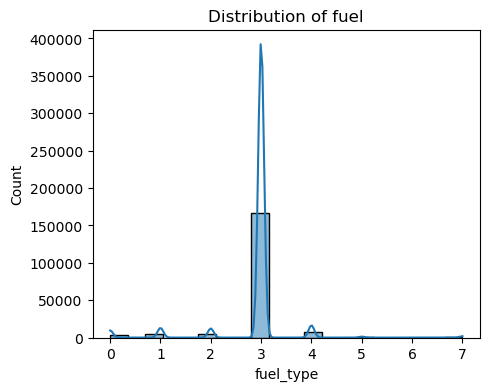

In [45]:
plt.figure(figsize=(5, 4))
sns.histplot(train_drop['fuel_type'], bins=20, kde=True)
plt.title('Distribution of fuel')
plt.show()

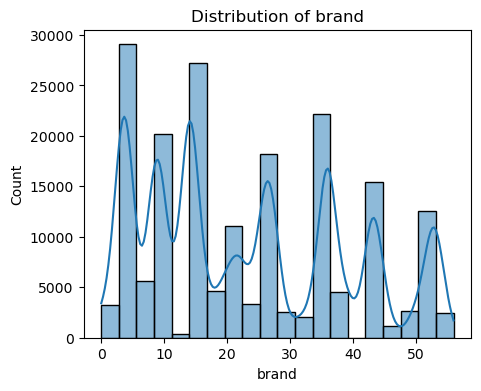

In [46]:
plt.figure(figsize=(5, 4))
sns.histplot(train_drop['brand'], bins=20, kde=True)
plt.title('Distribution of brand')
plt.show()

In [47]:
X = train_drop.drop(['id','price'],axis=1)
Y = train_drop['price']
X.shape, Y.shape

((188533, 12), (188533,))

In [48]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [49]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

In [50]:
model = LinearRegression()
model.fit(X_train_scaled, Y_train)

# Step 6: Make predictions
y_pred = model.predict(X_test_scaled)

In [51]:
rmse = np.sqrt(np.mean((np.expm1(y_pred) - np.expm1(Y_val))**2))

In [52]:
print("Linear Regression : ",rmse)

Linear Regression :  70574.66214351173


In [53]:
r2 = r2_score(Y_val, y_pred)
r2

0.5978805069835906

In [54]:
param_dist_en = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0],'l1_ratio': [0.0, 0.1, 0.5, 0.7, 1.0], 'max_iter': [1000, 2000, 3000, 5000], 'tol': [1e-4, 1e-3, 1e-2]}
elastic_net = ElasticNet(random_state=42)
random_search_en = RandomizedSearchCV(estimator=elastic_net,param_distributions=param_dist_en,n_iter=20,scoring='neg_mean_squared_error',cv=5,
    random_state=42
)

random_search_en.fit(X_train, Y_train)
best_params_en = random_search_en.best_params_
print("Best Parameters for Elastic Net:", best_params_en)
y_pre = random_search_en.predict(X_val)

rmse = np.sqrt(np.mean((np.expm1(y_pre) - np.expm1(Y_val))**2))

print(f'Optimized ElasticNet RMSE: {rmse:.2f}')

Best Parameters for Elastic Net: {'tol': 0.0001, 'max_iter': 5000, 'l1_ratio': 0.0, 'alpha': 0.001}
Optimized ElasticNet RMSE: 70575.04


In [55]:
r2 = r2_score(Y_val, y_pre)
r2

0.5978787524028881

In [56]:
rf_model = RandomForestRegressor(n_estimators=100,  max_depth=10,  random_state=42)
rf_model.fit(X_train_scaled, Y_train)
y_pred2 = rf_model.predict(X_test_scaled)

In [57]:
rmse = np.sqrt(np.mean((np.expm1(y_pred2) - np.expm1(Y_val))**2))

In [58]:
print(rmse)

69206.88760171043


In [59]:
r2 = r2_score(Y_val, y_pred2)

In [60]:
r2

0.6448899406601349

In [61]:
catboost_estimator = CatBoostRegressor(silent=True)

In [62]:
param_dist = {'iterations': np.arange(100, 1000, 100),'depth': np.arange(4, 10),'learning_rate': np.linspace(0.01, 0.3, 10),
    'l2_leaf_reg': np.logspace(-3, 2, 6),'bagging_temperature': np.linspace(0.0, 1.0, 5),'border_count': np.arange(30, 150, 10)}

In [63]:
randomc_search = RandomizedSearchCV(estimator=catboost_estimator,param_distributions=param_dist, 
    n_iter=20, scoring='neg_root_mean_squared_error', cv=5,verbose=1,random_state=42,n_jobs=-1)

randomc_search.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001C36661B8F0>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bagging_temperature': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                                        'border_count': array([ 30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140]),
                                        'depth': array([4, 5, 6, 7, 8, 9]),
                                        'iterations': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                                        'l2_leaf_reg': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [64]:
y_ctb_pred = randomc_search.predict(X_val)
y_ctb_pred

array([10.5997507 ,  9.85976986, 10.37698654, ...,  9.89929809,
        9.34746722, 10.00802494])

In [65]:
rmse = np.sqrt(np.mean((np.expm1(y_ctb_pred) - np.expm1(Y_val))**2))
rmse

68669.43934469443

In [66]:
lgb_estimator = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse')

In [67]:
param_dist = {'num_leaves': np.arange(20, 150, 10),'learning_rate': np.linspace(0.01, 0.3, 10),'n_estimators': np.arange(100, 1000, 100),
    'feature_fraction': np.linspace(0.5, 0.9, 5)}

In [68]:
random= RandomizedSearchCV(estimator=lgb_estimator,param_distributions=param_dist,n_iter=20, 
    scoring='neg_root_mean_squared_error',cv=5,verbose=1,random_state=42,n_jobs=-1)

In [69]:
random.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 12
[LightGBM] [Info] Start training from score 10.291542


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(metric='rmse',
                                           objective='regression'),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'feature_fraction': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [70]:
y_lgb_pred = random.predict(X_val)
y_lgb_pred

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


array([10.65081851,  9.75959165, 10.30451988, ...,  9.82307267,
        9.34307573, 10.21761036])

In [71]:
rmse = np.sqrt(np.mean((np.expm1(y_lgb_pred) - np.expm1(Y_val))**2))
rmse

68687.2219626327

In [72]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam


modelann = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='linear')  
])


modelann.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.005))

es = EarlyStopping(monitor='val_loss', patience=19, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=19, min_lr=1e-6)

history = modelann.fit(X_train, Y_train, epochs=100, batch_size=128, validation_data=(X_val, Y_val),
                    callbacks=[es, lr]
                   )

Epoch 1/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 16.4506 - val_loss: 0.4398 - learning_rate: 0.0050
Epoch 2/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3423 - val_loss: 0.3856 - learning_rate: 0.0050
Epoch 3/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3195 - val_loss: 0.3913 - learning_rate: 0.0050
Epoch 4/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3214 - val_loss: 0.3702 - learning_rate: 0.0050
Epoch 5/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3120 - val_loss: 0.3028 - learning_rate: 0.0050
Epoch 6/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3070 - val_loss: 0.4455 - learning_rate: 0.0050
Epoch 7/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3173 - val_loss: 0.3373 - learning_rate: 0.0050
Epoch 8/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3183 - val_loss: 0.3467 - learning_rate: 0.0050
Epoch 9/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3192 - val_loss: 0.3064 - lea

In [73]:
ann_pred = modelann.predict(X_val).flatten()
rmse = np.sqrt(np.mean((np.expm1(ann_pred) - np.expm1(Y_val))**2))

print(f'ANN RMSE: {rmse:.2f}')

1179/1179 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
ANN RMSE: 70868.62


In [75]:
X_test = test_drop.drop(['id'],axis=1)
lgb_pred = random.predict(X_test)
cat_pred = randomc_search.predict(X_test)
ann_pred = modelann.predict(X_test)
blended_pred_test = (lgb_pred / 68687.22 + cat_pred / 68669.43 + ann_pred /70290.26) / (1/68687.22 + 1/68669.43 + 1/68755.27 +1/70290.26)
blended_pred_test

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


NameError: name 'xgb_pred' is not defined

In [ ]:
blended_pred_test = np.expm1(blended_pred_test)
blended_pred_test

In [ ]:
predict = pd.DataFrame({'id': car_price_test['id'],'predicted_price': blended_pred_test})
predict.head(5)

In [ ]:
submission = pd.DataFrame({
    'id': test_drop['id'],  
    'price': blended_pred_test
})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

In [ ]:
import os
file_name = 'car_price_predict.csv'
submission.to_csv(file_name, index=False)
current_directory = os.getcwd()
file_path = os.path.join(current_directory, file_name)
print(f"Predictions saved to: {file_path}")